# Previsão Eleição de Deputados

### Aluno: Gustavo Silva Medeiros

In [40]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from scipy.stats import skew
from scipy.stats.stats import pearsonr
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from yellowbrick.model_selection import FeatureImportances

In [2]:
from google.colab import drive
drive.mount("/content/drive")
%cd "/content/drive/My Drive/Colab Notebooks"
TRAIN_PATH = "train.csv"
FINAL_TEST_PATH = "test.csv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks


## Carregando e analisando os dados:

In [3]:
# carrega os dados de treino e teste e transforma a coluna "nome" em index
df = pd.read_csv(TRAIN_PATH, index_col="sequencial_candidato")
all_data = df.copy()
final_test = pd.read_csv(FINAL_TEST_PATH, index_col="sequencial_candidato")

In [4]:
list(all_data.columns)

['ano',
 'nome',
 'uf',
 'partido',
 'quantidade_doacoes',
 'quantidade_doadores',
 'total_receita',
 'media_receita',
 'recursos_de_outros_candidatos.comites',
 'recursos_de_pessoas_fisicas',
 'recursos_de_pessoas_juridicas',
 'recursos_proprios',
 'recursos_de_partido_politico',
 'quantidade_despesas',
 'quantidade_fornecedores',
 'total_despesa',
 'media_despesa',
 'cargo',
 'sexo',
 'grau',
 'estado_civil',
 'ocupacao',
 'situacao']

In [5]:
list(final_test.columns)

['ano',
 'nome',
 'uf',
 'partido',
 'quantidade_doacoes',
 'quantidade_doadores',
 'total_receita',
 'media_receita',
 'recursos_de_outros_candidatos.comites',
 'recursos_de_pessoas_fisicas',
 'recursos_de_pessoas_juridicas',
 'recursos_proprios',
 'recursos_de_partido_politico',
 'quantidade_despesas',
 'quantidade_fornecedores',
 'total_despesa',
 'media_despesa',
 'cargo',
 'sexo',
 'grau',
 'estado_civil',
 'ocupacao']

## Preparando os dados:

In [6]:
# remove as colunas que não são desejadas
def remove_columns(data, columns):
  for col in columns:
    data = data.drop(col, axis=1)
  return data

columns_to_remove = ['ano', 'nome', 'cargo', 'ocupacao', 'estado_civil', 'uf']
all_data = remove_columns(all_data, columns_to_remove)
final_test = remove_columns(final_test, columns_to_remove)
train, test = train_test_split(all_data, train_size=0.8)

# remove a coluna "situação"
all_data = all_data.drop("situacao", axis=1)

In [7]:
print(f"Total de linhas em train: {len(train)}")
train.head()

Total de linhas em train: 6097


,partido,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos.comites,recursos_de_pessoas_fisicas,recursos_de_pessoas_juridicas,recursos_proprios,recursos_de_partido_politico,quantidade_despesas,quantidade_fornecedores,total_despesa,media_despesa,sexo,grau,situacao
sequencial_candidato,,,,,,,,,,,,,,,,,
10136,PSDB,55,50,580354.50,10551.90,1550.00,145100.00,411704.5,22000.0,0.0,221,188,554782.44,2510.33,MASCULINO,SUPERIOR COMPLETO,eleito
10754,PSDB,19,19,60900.00,3205.26,0.00,24100.00,28500.0,8300.0,0.0,43,41,63543.68,1477.76,MASCULINO,SUPERIOR COMPLETO,nao_eleito
12615,PT,72,67,410064.14,5695.34,29563.86,80726.28,231751.4,16825.0,51197.6,291,273,407412.59,1400.04,FEMININO,SUPERIOR COMPLETO,nao_eleito
210000000685,PMDB,19,19,83376.52,4388.24,1476.52,0.00,71800.0,100.0,10000.0,96,88,89338.05,930.60,MASCULINO,ENSINO MÉDIO COMPLETO,nao_eleito
190000001668,PMDB,53,42,1461452.40,27574.57,410797.40,12000.00,538655.0,0.0,500000.0,1322,624,1252589.01,947.50,MASCULINO,SUPERIOR COMPLETO,eleito


In [8]:
print(f"Total de linhas em test: {len(test)}")
test.head()

Total de linhas em test: 1525


,partido,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos.comites,recursos_de_pessoas_fisicas,recursos_de_pessoas_juridicas,recursos_proprios,recursos_de_partido_politico,quantidade_despesas,quantidade_fornecedores,total_despesa,media_despesa,sexo,grau,situacao
sequencial_candidato,,,,,,,,,,,,,,,,,
10602,PC do B,4,4,8705.00,2176.25,0.00,8705.0,0.0,0.0,0.0,25,25,8558.56,342.34,FEMININO,ENSINO MÉDIO INCOMPLETO,nao_eleito
10089,PFL,4,3,4750.00,1187.50,0.00,0.0,0.0,4750.0,0.0,9,9,4748.57,527.62,MASCULINO,SUPERIOR COMPLETO,nao_eleito
250000001353,PT,7,7,8696.58,1242.37,8696.58,0.0,0.0,0.0,0.0,7,7,8696.58,1242.37,MASCULINO,SUPERIOR COMPLETO,nao_eleito
12411,PSB,3,3,2842.00,947.33,0.00,0.0,0.0,2842.0,0.0,7,6,2640.88,377.27,FEMININO,ENSINO FUNDAMENTAL COMPLETO,nao_eleito
160000000025,PSB,34,34,347280.00,10214.12,11130.00,116200.0,114950.0,105000.0,0.0,310,288,328424.05,1059.43,MASCULINO,ENSINO MÉDIO COMPLETO,nao_eleito


In [9]:
print(f"Total de linhas em all_data: {len(all_data)}")
all_data.head()

Total de linhas em all_data: 7622


,partido,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos.comites,recursos_de_pessoas_fisicas,recursos_de_pessoas_juridicas,recursos_proprios,recursos_de_partido_politico,quantidade_despesas,quantidade_fornecedores,total_despesa,media_despesa,sexo,grau
sequencial_candidato,,,,,,,,,,,,,,,,
10001,PT,6,6,16600.00,2766.67,0.0,9000.0,6300.00,1300.0,0.0,14,14,16583.60,1184.54,MASCULINO,ENSINO MÉDIO COMPLETO
10002,PT,13,13,22826.00,1755.85,6625.0,15000.0,1000.00,201.0,0.0,24,23,20325.99,846.92,FEMININO,SUPERIOR COMPLETO
10002,PT,17,16,158120.80,9301.22,2250.0,34150.0,62220.80,59500.0,0.0,123,108,146011.70,1187.09,FEMININO,SUPERIOR COMPLETO
10002,PRONA,6,6,3001.12,500.19,0.0,1150.0,1101.12,750.0,0.0,8,8,3001.12,375.14,MASCULINO,ENSINO MÉDIO INCOMPLETO
10003,PT,48,48,119820.00,2496.25,0.0,50878.0,0.00,68942.0,0.0,133,120,116416.64,875.31,MASCULINO,ENSINO FUNDAMENTAL COMPLETO


In [10]:
all_data.describe()

,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos.comites,recursos_de_pessoas_fisicas,recursos_de_pessoas_juridicas,recursos_proprios,recursos_de_partido_politico,quantidade_despesas,quantidade_fornecedores,total_despesa,media_despesa
count,7622.000000,7622.000000,7.622000e+03,7622.000000,7.622000e+03,7.622000e+03,7.622000e+03,7.622000e+03,7.622000e+03,7622.000000,7622.000000,7.622000e+03,7622.000000
mean,27.673839,25.239963,1.732199e+05,5456.131027,1.965750e+04,2.315820e+04,7.921689e+04,2.577600e+04,2.541136e+04,130.485174,107.849777,1.554507e+05,1346.643975
std,116.511888,101.804938,4.444187e+05,14003.313610,1.041636e+05,6.689215e+04,2.514138e+05,1.495312e+05,1.308613e+05,411.039689,333.905884,3.901120e+05,6164.552399
min,1.000000,1.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000,1.000000,0.000000e+00,0.000000
25%,4.000000,3.000000,2.829207e+03,625.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000,5.000000,2.689600e+03,352.500000
50%,9.000000,8.000000,1.334511e+04,1537.775000,1.125000e+03,1.350000e+03,0.000000e+00,1.121600e+03,0.000000e+00,20.000000,18.000000,1.226735e+04,711.365000
75%,23.000000,21.000000,1.046682e+05,4666.247500,6.196375e+03,1.574625e+04,1.725875e+04,9.600000e+03,0.000000e+00,80.000000,68.000000,9.633950e+04,1399.812500
max,6997.000000,5800.000000,5.690642e+06,500180.000000,3.664205e+06,1.403049e+06,3.178226e+06,5.525600e+06,2.745700e+06,9932.000000,8359.000000,4.989491e+06,500177.000000


## Normalizando os dados numéricos:

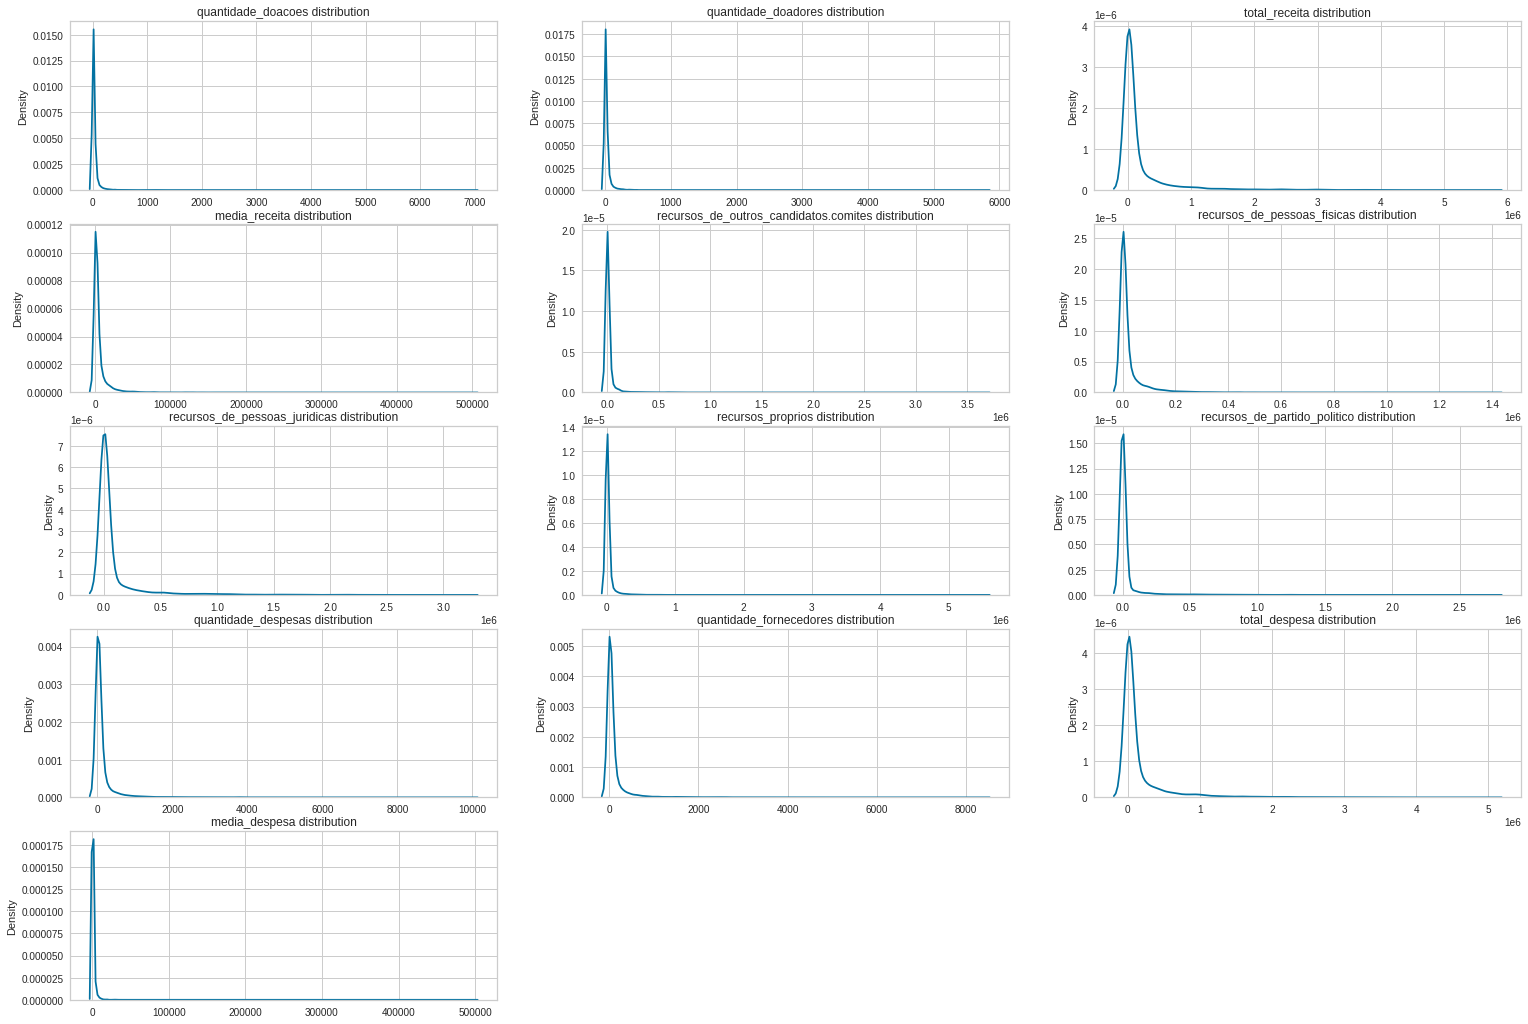

In [11]:
def show_kde_density_curves(df, attributes, max_cols=3):
  max_rows = math.ceil(len(attributes) / max_cols)
  plt.figure(figsize=(26, 18)) 
  for i, attr in enumerate(attributes):
    plt.subplot(max_rows, max_cols, i + 1)
    plt.title(f'{attr} distribution')
    sns.kdeplot(df[attr].values)
  plt.show()
  
# obtem as colunas numéricas:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# exibe as curvas de densidade dos atributos (análogo a um histograma)
show_kde_density_curves(all_data, numeric_feats)

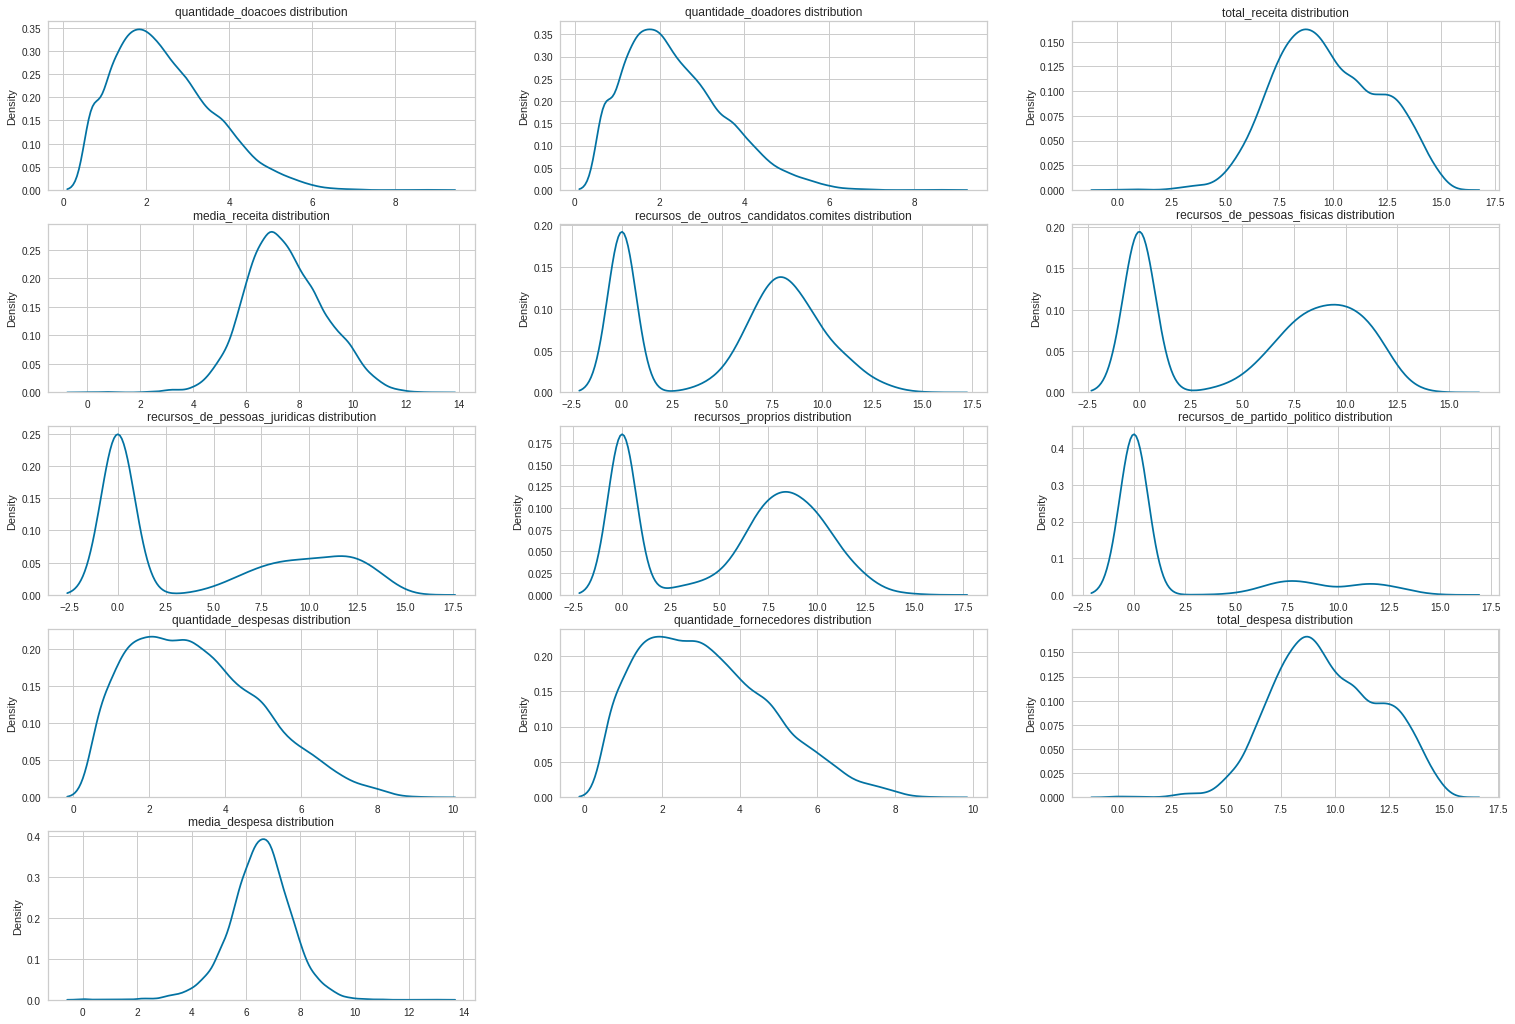

In [12]:
# normaliza os dados numéricos
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna()))
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

show_kde_density_curves(all_data, numeric_feats)

## Convertendo dados categóricos em variáveis ​​fictícias ou indicadoras:

In [13]:
# obtem as colunas não numéricas
non_numeric_feats = all_data.dtypes[all_data.dtypes == "object"].index

# converte os dados categóricos
all_data = pd.get_dummies(all_data, columns=non_numeric_feats)
all_data.head()

,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos.comites,recursos_de_pessoas_fisicas,recursos_de_pessoas_juridicas,recursos_proprios,recursos_de_partido_politico,quantidade_despesas,...,partido_PV,sexo_FEMININO,sexo_MASCULINO,grau_ENSINO FUNDAMENTAL COMPLETO,grau_ENSINO FUNDAMENTAL INCOMPLETO,grau_ENSINO MÉDIO COMPLETO,grau_ENSINO MÉDIO INCOMPLETO,grau_LÊ E ESCREVE,grau_SUPERIOR COMPLETO,grau_SUPERIOR INCOMPLETO
sequencial_candidato,,,,,,,,,,,,,,,,,,,,,
10001,1.945910,1.945910,9.717218,7.925761,0.000000,9.105091,8.748464,7.170888,0.0,2.708050,...,0,0,1,0,0,1,0,0,0,0
10002,2.639057,2.639057,10.035699,7.471278,8.798757,9.615872,6.908755,5.308268,0.0,3.218876,...,0,1,0,0,0,0,0,0,1,0
10002,2.890372,2.833213,11.971121,9.138008,7.719130,10.438547,11.038461,10.993748,0.0,4.820282,...,0,1,0,0,0,0,0,0,1,0
10002,1.945910,1.945910,8.007074,6.216985,0.000000,7.048386,7.004991,6.621406,0.0,2.197225,...,0,0,1,0,0,0,1,0,0,0
10003,3.891820,3.891820,11.693754,7.822945,0.000000,10.837206,0.000000,11.141035,0.0,4.897840,...,0,0,1,1,0,0,0,0,0,0


## Preenchendo os valores NaN com a média da coluna:

In [14]:
all_data = all_data.fillna(all_data.mean())

In [15]:
# verifica se ainda existem valores NaN
all_data.isna().sum().sum()

0

## Proporção entre as classes:

In [16]:
df.groupby("situacao").size()

situacao
eleito        1026
nao_eleito    6596
dtype: int64

In [17]:
proportion = len(df[df.situacao == "nao_eleito"]) / len(df)
print(f"Proporção de instâncias da classe 'nao_eleito': {proportion:.2%}")
print(f"Proporção de instâncias da classe 'eleito': {1 - proportion:.2%}")

Proporção de instâncias da classe 'nao_eleito': 86.54%
Proporção de instâncias da classe 'eleito': 13.46%


## Atividade:

Nessa atividade você irá usar seus conhecimentos sobre classificação para prever quais candidatos à Câmara de Deputados serão eleitos nas eleições de 2014. De forma específica faremos o seguinte:

**1) Há desbalanceamento das classes (isto é, uma classe tem muito mais instâncias que outra)? Em que proporção? Quais efeitos colaterais o desbalanceamento de classes pode causar no classificador? Como você poderia tratar isso? (10 pt.)**

Há desbalanceamento entre as classes “eleito” e “nao_eleito”, onde 86,54% das instâncias são da classe “nao_eleito” e 13,46% da classe “eleito” (classe minoritária). Isso faz com que o dataset tenha muitas informações sobre a classe mais incidente, e menos sobre a classe minoritária, o que pode interferir no treinamento do modelo e na geração de previsões. Se o modelo gerado não considerar essa desproporcionalidade nos dados, os parâmetros do algoritmo podem não diferenciar a classe minoritária e considerar que estes dados não são relevantes para o resultado.

Para tratar esse problema, podemos reestruturar os dados para tentar igualar o número de observações entre as classes; usar um algorítmo que possua um melhor desempenho com dados desbalanceados; coletar mais dados para tentar atingir o balanceamento; usar modelos penalizados com diferentes funções de custo que adicionam uma penalidade maior para erros de classificação da categoria minoritária; alterar a acurácia como métrica de treino; verificar o desempenho do modelo com diferentes métricas para tentar encontrar possíveis problemas com dados desbalanceados.

**2) Treine: um modelo de regressão logística, uma árvore de decisão, um modelo de adaboost, um modelo de random forest e um modelo de gradient boosting. Tune esses modelos usando validação cruzada e controle overfitting se necessário, considerando as particularidades de cada modelo.  (10 pts.)**

In [62]:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]

le = LabelEncoder()
y_train = train.situacao
le.fit(y_train)
y_train = le.transform(y_train)

y_test = test.situacao
le.fit(y_test)
y_test = le.transform(y_test)

model_accuracy = {"Model": [], "Train Accuracy": [], "Test Accuracy": []}
precision_recall_fscore = {"Model": [], "Precision": [], "Recall": [], "Fscore": []}

def add_precision_recall_fscore(name, metrics):
  global precision_recall_fscore
  precision, recall, fscore = metrics
  precision_recall_fscore["Model"].append(name)
  precision_recall_fscore["Precision"].append(precision)
  precision_recall_fscore["Recall"].append(recall)
  precision_recall_fscore["Fscore"].append(fscore)

def add_model_accuracy(name, train_accuracy, test_accuracy):
  global model_accuracy
  model_accuracy["Model"].append(name)
  model_accuracy["Train Accuracy"].append(train_accuracy)
  model_accuracy["Test Accuracy"].append(test_accuracy)

def cv_score(model):
  global X_train, y_train
  return cross_val_score(model, X_train, y_train, cv=KFold(n_splits=10), scoring="precision")

def get_acurracy(model):
  global X_train, X_test, y_train, y_test
  model = model.fit(X_train, y_train)
  predictions = model.predict(X_test)
  train_accuracy = accuracy_score(y_train, model.predict(X_train))
  test_accuracy = accuracy_score(y_test, predictions)
  return train_accuracy, test_accuracy

def get_precision_recall_fscore(model):
  y_pred_train = model.predict(X_train)
  precision, recall, fscore, support = precision_recall_fscore_support(y_train, y_pred_train, average="macro", zero_division=1)
  return precision, recall, fscore

def plot_acuracy(train_acurracy, test_acurracy, depths, title):
  plt.plot(depths, train_acurracy, 'r', label='Training Score')
  plt.plot(depths, test_acurracy, 'b', label='Test Score')
  plt.title(title)
  plt.legend(loc=0)
  plt.figure()
  plt.show()

## Regressão Logística

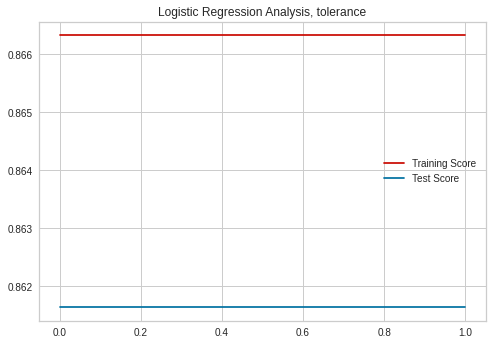

<Figure size 576x396 with 0 Axes>

In [19]:
tolerances = [0.0001, 0.001, 0.01, 0.1, 1]
acurracy = [get_acurracy(LogisticRegression(tol=t, max_iter=1000)) for t in tolerances]
train_acurracy = [item[0] for item in acurracy]
test_acurracy = [item[1] for item in acurracy]
plot_acuracy(train_acurracy, test_acurracy, tolerances, 'Logistic Regression Analysis, tolerance')
test_acurracy = pd.Series(test_acurracy, index=tolerances)

In [20]:
(test_acurracy.max(), test_acurracy.idxmax())

(0.861639344262295, 0.0001)

In [63]:
model = LogisticRegression(tol=test_acurracy.idxmax(), max_iter=1000)
model = model.fit(X_train, y_train)
predictions = model.predict(X_test)
train_accuracy = accuracy_score(y_train, model.predict(X_train))
test_accuracy = accuracy_score(y_test, predictions)
add_model_accuracy("LogisticRegression", train_accuracy, test_accuracy)
add_precision_recall_fscore("LogisticRegression", get_precision_recall_fscore(model))

print("Train Accuracy : ", train_accuracy)
print("Test Accuracy  : ", test_accuracy)
print("Confusion matrix:\n ", confusion_matrix(y_test, predictions))

Train Accuracy :  0.8663277021485977
Test Accuracy  :  0.861639344262295
Confusion matrix:
  [[   0  211]
 [   0 1314]]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/yellowbrick/model_selection/importances.py:199: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  YellowbrickWarning,


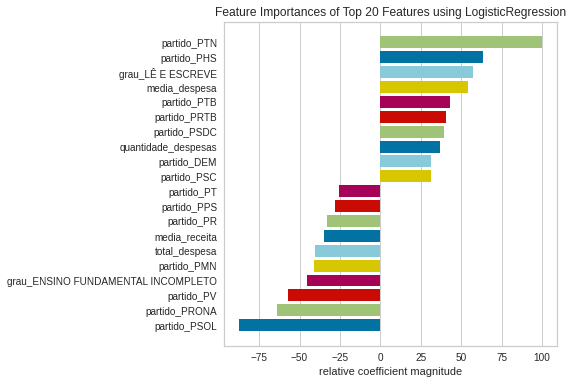

In [22]:
imp = FeatureImportances(model, topn=20)
imp.fit(X_train, y_train)
imp.show()

## Árvore de Decisão

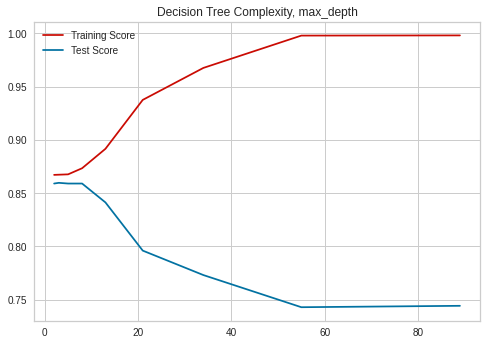

<Figure size 576x396 with 0 Axes>

In [23]:
depths = [2, 3, 5, 8, 13, 21, 34, 55, 89]
acurracy = [get_acurracy(DecisionTreeClassifier(max_depth=d, random_state=42)) for d in depths]
train_acurracy = [item[0] for item in acurracy]
test_acurracy = [item[1] for item in acurracy]
plot_acuracy(train_acurracy, test_acurracy, depths, 'Decision Tree Complexity, depth')
test_acurracy = pd.Series(test_acurracy, index=depths)

In [24]:
(test_acurracy.max(), test_acurracy.idxmax())

(0.8596721311475409, 3)

In [64]:
model = DecisionTreeClassifier(max_depth=test_acurracy.idxmax(), random_state=42)
model = model.fit(X_train, y_train)
predictions = model.predict(X_test)
train_accuracy = accuracy_score(y_train, model.predict(X_train))
test_accuracy = accuracy_score(y_test, predictions)
add_model_accuracy("DecisionTreeClassifier", train_accuracy, test_accuracy)
add_precision_recall_fscore("DecisionTreeClassifier", get_precision_recall_fscore(model))

print("Train Accuracy : ", train_accuracy)
print("Test Accuracy  : ", test_accuracy)
print("Confusion matrix:\n ", confusion_matrix(y_test, predictions))

Train Accuracy :  0.8663277021485977
Test Accuracy  :  0.861639344262295
Confusion matrix:
  [[   0  211]
 [   0 1314]]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"


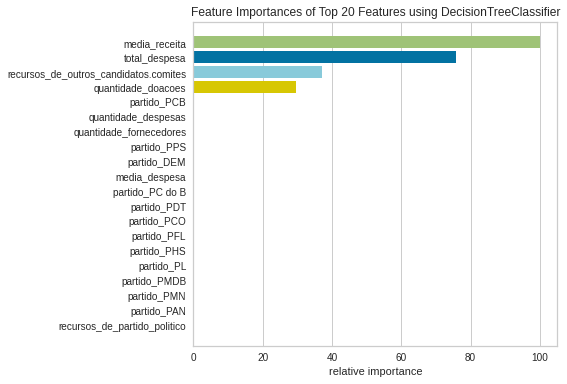

In [26]:
imp = FeatureImportances(model, topn=20)
imp.fit(X_train, y_train)
imp.show()

## Adaboost

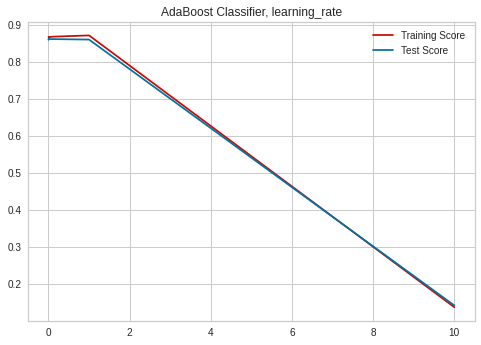

<Figure size 576x396 with 0 Axes>

In [27]:
learning_rates = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]
acurracy = [get_acurracy(AdaBoostClassifier(learning_rate=l, random_state=42, n_estimators=200)) for l in learning_rates]
train_acurracy = [item[0] for item in acurracy]
test_acurracy = [item[1] for item in acurracy]
plot_acuracy(train_acurracy, test_acurracy, learning_rates, 'AdaBoost Classifier, learning_rate')
test_acurracy = pd.Series(test_acurracy, index=learning_rates)

In [28]:
(test_acurracy.max(), test_acurracy.idxmax())

(0.860983606557377, 0.0001)

In [65]:
model = AdaBoostClassifier(learning_rate=test_acurracy.idxmax(), random_state=42, n_estimators=200)
model = model.fit(X_train, y_train)
predictions = model.predict(X_test)
train_accuracy = accuracy_score(y_train, model.predict(X_train))
test_accuracy = accuracy_score(y_test, predictions)
add_model_accuracy("AdaBoostClassifier", train_accuracy, test_accuracy)
add_precision_recall_fscore("AdaBoostClassifier", get_precision_recall_fscore(model))

print("Train Accuracy : ", train_accuracy)
print("Test Accuracy  : ", test_accuracy)
print("Confusion matrix:\n ", confusion_matrix(y_test, predictions))

Train Accuracy :  0.8668197474167624
Test Accuracy  :  0.860983606557377
Confusion matrix:
  [[   0  211]
 [   1 1313]]


## Random Forest

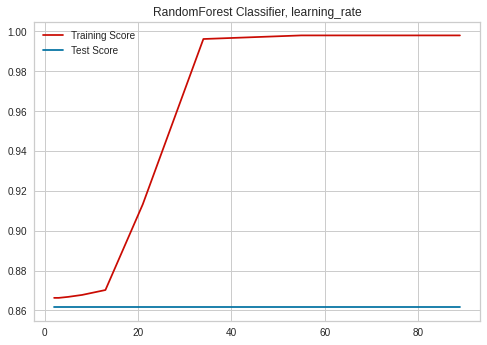

<Figure size 576x396 with 0 Axes>

In [30]:
depths = [2, 3, 5, 8, 13, 21, 34, 55, 89]
acurracy = [get_acurracy(RandomForestClassifier(max_depth=d, random_state=42, n_estimators=200)) for d in depths]
train_acurracy = [item[0] for item in acurracy]
test_acurracy = [item[1] for item in acurracy]
plot_acuracy(train_acurracy, test_acurracy, depths, 'RandomForest Classifier, depth')
test_acurracy = pd.Series(test_acurracy, index=depths)

In [31]:
(test_acurracy.max(), test_acurracy.idxmax())

(0.861639344262295, 2)

In [66]:
model = RandomForestClassifier(max_depth=test_acurracy.idxmax(), random_state=42, n_estimators=200)
model = model.fit(X_train, y_train)
predictions = model.predict(X_test)
train_accuracy = accuracy_score(y_train, model.predict(X_train))
test_accuracy = accuracy_score(y_test, predictions)
add_model_accuracy("DecisionTreeClassifier", train_accuracy, test_accuracy)
add_precision_recall_fscore("DecisionTreeClassifier", get_precision_recall_fscore(model))

print("Train Accuracy : ", train_accuracy)
print("Test Accuracy  : ", test_accuracy)
print("Confusion matrix:\n ", confusion_matrix(y_test, predictions))

Train Accuracy :  0.8663277021485977
Test Accuracy  :  0.861639344262295
Confusion matrix:
  [[   0  211]
 [   0 1314]]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


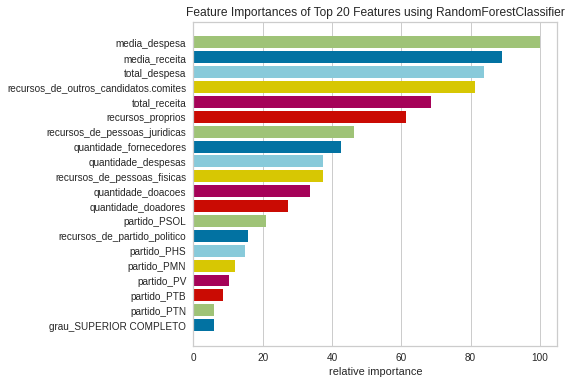

In [33]:
imp = FeatureImportances(model, topn=20)
imp.fit(X_train, y_train)
imp.show()

## Gradient Boosting

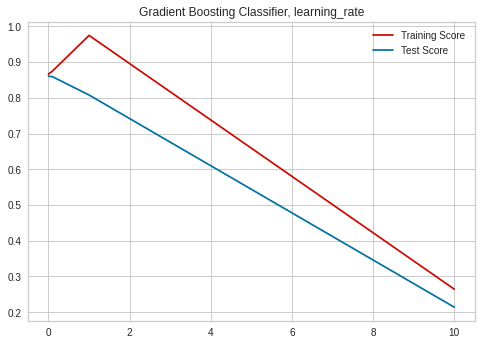

<Figure size 576x396 with 0 Axes>

In [35]:
learning_rates = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]
acurracy = [get_acurracy(GradientBoostingClassifier(learning_rate=l, random_state=42, n_estimators=200)) for l in learning_rates]
train_acurracy = [item[0] for item in acurracy]
test_acurracy = [item[1] for item in acurracy]
plot_acuracy(train_acurracy, test_acurracy, learning_rates, 'Gradient Boosting Classifier, learning_rate')
test_acurracy = pd.Series(test_acurracy, index=learning_rates)

In [36]:
(test_acurracy.max(), test_acurracy.idxmax())

(0.861639344262295, 0.0001)

In [67]:
model = GradientBoostingClassifier(learning_rate=test_acurracy.idxmax(), random_state=42, n_estimators=200)
model = model.fit(X_train, y_train)
predictions = model.predict(X_test)
train_accuracy = accuracy_score(y_train, model.predict(X_train))
test_accuracy = accuracy_score(y_test, predictions)
add_model_accuracy("GradientBoostingClassifier", train_accuracy, test_accuracy)
add_precision_recall_fscore("GradientBoostingClassifier", get_precision_recall_fscore(model))

print("Train Accuracy : ", train_accuracy)
print("Test Accuracy  : ", test_accuracy)
print("Confusion matrix:\n ", confusion_matrix(y_test, predictions))

Train Accuracy :  0.8663277021485977
Test Accuracy  :  0.861639344262295
Confusion matrix:
  [[   0  211]
 [   0 1314]]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  "X does not have valid feature names, but"


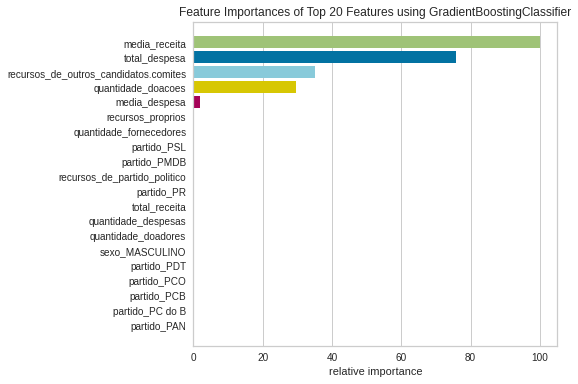

In [38]:
imp = FeatureImportances(model, topn=20)
imp.fit(X_train, y_train)
imp.show()

In [68]:
df_model_accuracy = pd.DataFrame(data=model_accuracy)
df_model_accuracy.sort_values(by=['Test Accuracy'], ascending=False)

,Model,Train Accuracy,Test Accuracy
0,LogisticRegression,0.866328,0.861639
1,DecisionTreeClassifier,0.866328,0.861639
3,DecisionTreeClassifier,0.866328,0.861639
4,GradientBoostingClassifier,0.866328,0.861639
2,AdaBoostClassifier,0.866820,0.860984


**3) Reporte precision, recall e f-measure no treino e validação. Há uma grande diferença de desempenho no treino/validação? Como você avalia os resultados? Justifique sua resposta. (10 pt.)**

In [69]:
df_model_precision_recall_fscore = pd.DataFrame(data=precision_recall_fscore)
df_model_precision_recall_fscore.sort_values(by=['Fscore'], ascending=False)

,Model,Precision,Recall,Fscore
2,AdaBoostClassifier,0.933377,0.50184,0.467978
0,LogisticRegression,0.933164,0.50000,0.464188
1,DecisionTreeClassifier,0.933164,0.50000,0.464188
3,DecisionTreeClassifier,0.933164,0.50000,0.464188
4,GradientBoostingClassifier,0.933164,0.50000,0.464188


**4) Interprete as saídas dos modelos. Quais atributos parecem ser mais importantes de acordo com cada modelo? (10 pts.)**

**5) Envie seus melhores modelos conforme resultados nos dados de teste. Sugestões para melhorar o modelo: (10 pts.)**

**a) Experimente outros modelos (e.g. SVM, RandomForests e GradientBoosting).**

**b) Experimente balancear as classes,  caso estejam desbalanceadas.**

Os dados de treino e teste estão neste link: https://www.kaggle.com/c/ufcg-cdp-20182-lab3/data (Links para um site externo.)

Para a entrega envie o link do seu notebook Colab com código e análise.